# CityBike Wien Datensetanalye für die Jahre 2016 und 2017

== Inhalt und Struktur dieses Notebooks 



## Datenset importieren bereinigen und transformieren

Die Daten werden zuerst eingelesen und nötige Transformationen werden vorgenommen. 

In erste Linie werden alle Fahrten die unter zwei Minuten dauern und an der gleichen Station enden aus dem Datenset herausgenommen da man davon ausgehen kann, dass der Nutzer das System nicht benutzt hat. 

In [2]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
#Warnungen seitens Jupyter sollen ignoriert werden
warnings.filterwarnings('ignore')

df2016 = pd.read_csv('CityBikeWien/2016trips.csv', error_bad_lines=False, parse_dates=['Startdatum', 'Enddatum'], delimiter=';')
df2017 = pd.read_csv('CityBikeWien/2017trips.csv', error_bad_lines=False, parse_dates=['Startdatum', 'Enddatum'], delimiter=';')

Die beiden DataFrames für die Jahre 2016 und 2017 werden zusammengeführt

In [3]:
df_total = df2016.append(df2017)

Bei dem neuen DataFrame wird der Index neu gesetzt

In [4]:
df_total = df_total.reset_index(drop=True)

Eine neue Spalte für die Fahrtdauer wird hinzugefügt (Enddatum-Startdatum)

In [5]:
df_total['Fahrtdauer'] =  df_total['Enddatum'] - df_total['Startdatum']
df2016['Fahrtdauer']   =  df2016['Enddatum']   - df2016['Startdatum']
df2017['Fahrtdauer']   =  df2017['Enddatum'] - df2017['Startdatum']

Uns interessieren nur Fahrten die länger als zwei Minuten dauern und gleichzeitig nicht an der gleichen Station beendet wurden. Die Bereinigung wird für alle dreit Datasets vorgenommen.

In [6]:
df_total_cleansed = df_total[ (df_total['Fahrtdauer'] > pd.Timedelta('120 sec')) 
                            & (df_total['Anfangsstation_ID'] != df_total['Endstation_ID'])]

df2016            = df2016[ (df2016['Fahrtdauer'] > pd.Timedelta('120 sec'))
                            & (df2016['Anfangsstation_ID'] != df2016['Endstation_ID'])]

df2017            = df2017[ (df2017['Fahrtdauer'] > pd.Timedelta('120 sec'))
                            & (df2017['Anfangsstation_ID'] != df2017['Endstation_ID'])]

Das bereinigte DataFrame enthält insgesamt 1.897.764 Einträge für die Jahre 2016 und 2017 mit folgenden Datentypen

In [7]:
df_total_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1897764 entries, 1 to 2080071
Data columns (total 7 columns):
Startdatum           datetime64[ns]
Enddatum             datetime64[ns]
Anfangsstation_ID    int64
Endstation_ID        int64
Fahrrad_ID           int64
Subscriber_ID        object
Fahrtdauer           timedelta64[ns]
dtypes: datetime64[ns](2), int64(3), object(1), timedelta64[ns](1)
memory usage: 115.8+ MB


Erste Zeile des DataFrames als Referenz

In [8]:
df_total_cleansed.head(1)

,Startdatum,Enddatum,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Subscriber_ID,Fahrtdauer
1,2016-01-01 00:13:04,2016-01-01 00:38:05,1026,1100,2539,0x04084286D0CC7FA3973C16F8306802A1,00:25:01


## Finde die ersten 10 Benutzer nach Benutzung für den gesamten Zeitraum (2016+2017)


In der folgenden Zelle wird das DataFrame anhand der 'Subscriber_ID' gruppiert. 

Darauffolgend wird eine Aggregatfunktion (np.size) auf das gruppierte Objekt angewendet um die Anzahl der Fahrten je Subscriber zu erhalten. Somit erhält man ein Series-Objekt welches sortiert werden muss. 

Um die Handhabung zu erleichtern wird das Series-Objekt zu einem DataFrame mit einer einzigen Spalte transformiert.

In [9]:
grouped_by_subscriber_groups              = df_total.groupby('Subscriber_ID')
aggregated_by_subscriber_series           = grouped_by_subscriber_groups['Fahrrad_ID'].agg(np.size)
aggregated_sorted_by_subscriber_series    = aggregated_by_subscriber_series.sort_values(ascending=False)
aggregated_by_subscriber_dataframe        = aggregated_sorted_by_subscriber_series.to_frame('ANZAHL_FAHRTEN')

Die ersten zehn Subscriber werden extrahiert und zudem wird eine Spalte mit dem Rang hinzugefügt. Danach wird das DataFrame ausgegeben. 

In [10]:
aggregated_by_subscriber_dataframe_top_10 = aggregated_by_subscriber_dataframe[:10]
aggregated_by_subscriber_dataframe_top_10['RANG'] = np.arange(1,11) 
aggregated_by_subscriber_dataframe_top_10

,ANZAHL_FAHRTEN,RANG
Subscriber_ID,,
0x30EF7C4D0C1211B47ADBA3295EF47C61,1790,1
0xB9AF912E74C4F6602CF849721E28B621,1400,2
0xAC44D643FD2F8AE0CCD64B35A269DCC1,1297,3
0x30F9A85D6ADB8CFA380C4EA7D77C574E,1281,4
0xCA316F5E99321FD79D33C3CAB1000DA5,1193,5
0xE88FAEE35C9817B6BD91961D8DD186E0,1028,6
0x62B4268B5D5AB0FD8B0FDC93D79498DD,1025,7
0x24384492DBD8ACA63F4C29FC8BC3B36A,1011,8
0xD372854C5186AB811AEE55325547CC85,1009,9


## Was hat der Benutzer mit den meisten Fahrten für die Nutzung des Systems bezahlt?

Der 'Citybike Wien'-Nutzer welcher das System innerhalb der beiden Jahren am meisten genutzt hat, fuhr insgesamt 1790 Fahrten. Es wäre interessant zu sehen was ihn die Nutzung des Systems über die Zeitdauer der beiden Jahre gekostet hat. 

Hierfür ist es nötig den Kostenplan von Citybike Wien zu kennen. Dieser ist progressiv eingestellt, das heißt, dass die erste Stunde kostenlos ist. Die zweite Stunde kostet einen Euro, die dritte das doppelte und die vierte Stunde dann vier Euro. Jede weitere Stunde kostet jeweils vier Euro. 

Wir suchen alle Fahrten für den Power-User heraus

In [11]:
df_user_1 = df_total[df_total['Subscriber_ID'] == '0x30EF7C4D0C1211B47ADBA3295EF47C61']

Wie oft hat der Nutzer das Limit der einen Stunde überschritten? Insgesamt 98 mal.

In [12]:
df_user_1[df_user_1['Fahrtdauer'] > pd.Timedelta('60 min')].size

98

Gab es Fälle bei denen die Fahrt länger als zwei Stunden dauerte? Nein

In [13]:
df_user_1[df_user_1['Fahrtdauer'] > pd.Timedelta('120 min')].size

0

Insgesamt fielen 98 kostenpflichtige Fahrten an welche weniger als zwei Stunden gedauert haben. Somit hat der Anwender insgesamt 98 Euro für die Nutzung des Systems für die Zeitdauer der beiden Jahren bezahlt da jede Fahrt genau einen Euro gekostet hat.

Im Schnitt hat der oder die NutzerIn ~ 5,5 Cent für jede Fahrt bezahl.


## Welchen Umsatz hat das System für das Jahr 2016 bzw. 2017 generiert?

Es wäre interessant zu sehen wie viel Umsatz alleine durch die Nutzung des Systems entstanden ist. 

Der Betreiber von CityBike Wien, die Gewista GmbH wählt ein hybrides Finanzierungsmodell. Das heißt, dass sich das System nicht nur aus den Beiträgen der einzelnen Nutzer finanziert, sondern auch aus Werbungen welche auf den Fahrrädern angezeigt werden. Inwieweit oder ob das System durch die Stadt Wien subventioniert wird ist nicht bekannt. 

Wir untersuchen nun die Einnahmen welche durch die Nutzergemeinde des Systems entsteht. Dies ist durch die Kenntniss des Kostenmodells und der Länge der einzelnen Fahrten möglich. Die Anmeldegebühr von einem Euro wird nicht mit in die Berechnung einbezogen da aus dem Datenset nicht bekannt ist wann sich der Nutzer das erste Mal registriert hat. Somit könnte es sein, dass die Anmeldegebühr nicht in den Jahren 2016 oder 2017 verrechnet wurde. 

Um die Gebühr für die Fahrt zu berechnen ist es nötig eine passende Funktion zu definieren:

In [14]:
def calculate_fare(fahrtdauer):
    if(fahrtdauer < pd.Timedelta('60 min')):        
        return int(0)
    elif( (fahrtdauer > pd.Timedelta('60 min')) & (fahrtdauer < pd.Timedelta('120 min'))):
        return int(1)
    elif( (fahrtdauer > pd.Timedelta('120 min')) & (fahrtdauer < pd.Timedelta('180 min'))):
        return int(3)
    elif( (fahrtdauer > pd.Timedelta('180 min')) & (fahrtdauer < pd.Timedelta('240 min'))):
        return int(7)
    elif((fahrtdauer > pd.Timedelta('240 min')) & (fahrtdauer < pd.Timedelta('7200 min'))):
        return ( int(7) +  ((math.ceil(fahrtdauer.total_seconds() // 3600))-3)*4)
    elif(fahrtdauer > pd.Timedelta('7200 min')):
        return int(600)

Der Fahrtpreis wird für 2016 berechnet

In [15]:
df2016['Fahrtpreis'] = df2016['Fahrtdauer'].apply(calculate_fare)
df2017['Fahrtpreis'] = df2017['Fahrtdauer'].apply(calculate_fare)
df_total_cleansed['Fahrtpreis'] = df_total_cleansed['Fahrtdauer'].apply(calculate_fare)

Umsatz aus Fahrtpreisen 2016:

In [97]:
df2016['Fahrtpreis'].sum()

200391.0

Umsatz aus Fahrtpreisen 2017:

In [98]:
df2017['Fahrtpreis'].sum()

197716.0

## Wie viele Fahrräder wurden 2016/2017 entwendet?

Auf der Webseite von CityBike Wien wird angegebeben, dass eine Gebühr von 600 Euro verrechnet wird sollte das Fahrrad nicht innerhalb von 120 Stunden (5 Tagen) zurückgegeben werden. Ob aus Gründen von Diebstahl oder Zeitüberschreitung spielt keine Rolle.

In [17]:
df2016[df2016['Fahrtdauer'] > pd.Timedelta('7200 min')]

,Startdatum,Enddatum,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Subscriber_ID,Fahrtdauer,Fahrtpreis
135485,2016-04-04 03:16:37,2016-04-10 11:41:28,1033,11,3392,0x07C6A16845C84A5C763075C0AC4D68D8,6 days 08:24:51,600.0
135486,2016-04-04 03:20:11,2016-04-10 11:41:28,1033,11,3191,0x07C6A16845C84A5C763075C0AC4D68D8,6 days 08:21:17,600.0
568650,2016-07-18 01:02:17,2016-07-24 09:20:04,1032,11,1982,0x79FDEEFD920B3B353F3757273D97529B,6 days 08:17:47,600.0
708929,2016-08-16 15:36:22,2016-08-22 23:51:36,1086,11,1948,0x57C66E447D19E7F0EEC1B89995018D6C,6 days 08:15:14,600.0
965089,2016-10-21 12:18:58,2016-10-27 20:39:43,1128,11,2190,0xCB802DA7BE64212DA28B2B6602D01B21,6 days 08:20:45,600.0


Die Fahrräder mit den IDs: 3392, 3191, 1948, 2190 wurden nach dem Enddatum im System nicht wieder benutzt, somit können wir mit Sicherheit sagen, dass diese entwendet wurden. Das Fahrrad mit der ID: 1982 taucht im System wieder auf. Der Nutzer hat die Frist von 120 Stunden überschritten. In diesem Fall fällt die Pauschale von 600 Euro an.

Interessanterweise wurden die Fahrräder mit den IDs 3392 und 3191 von der gleichen Person ausgeliehen und darauffolgends entwendet.

Somit wurden im Jahr 2016 vier Fahrräder gestohlen. 

### Wie sieht die Lage für das darauffolgende Jahr aus?

In [18]:
df2017[df2017['Fahrtdauer'] > pd.Timedelta('7200 min')]

,Startdatum,Enddatum,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Subscriber_ID,Fahrtdauer,Fahrtpreis
16034,2017-01-18 20:54:05,2017-01-25 05:14:14,1054,11,2138,0x7DBDD6C7B20622B8AD58D70B9D431BB4,6 days 08:20:09,600.0
19124,2017-04-05 03:35:45,2017-04-11 11:51:48,1112,11,2408,0xF7521820428B7F25DBA5345EDDA1025C,6 days 08:16:03,600.0
22298,2017-05-21 01:18:01,2017-05-27 09:34:32,1025,11,2075,0x88F29882B4614746033E13829EBEBD1C,6 days 08:16:31,600.0
28927,2017-08-27 02:08:03,2017-09-02 10:19:44,1055,11,3157,0xB60B30694F42EA56652BEFEA6A3BD249,6 days 08:11:41,600.0
29801,2017-09-20 13:42:46,2017-09-26 21:57:17,1145,11,55,0x3F2B5608F8E8A6B9DD556CECFA87E3FC,6 days 08:14:31,600.0
30038,2017-09-29 11:19:42,2017-10-05 19:33:43,1077,11,2065,0x17779C3C345DE2E12172556CF244EFE3,6 days 08:14:01,600.0
30047,2017-09-29 14:31:20,2017-10-05 22:49:35,1115,11,2271,0x1E10D94BEEB562ADCC948444A85FE9BF,6 days 08:18:15,600.0
31389,2017-12-09 02:07:45,2017-12-15 10:29:34,1075,11,2798,0x2F27BFD4FC7D8FEC7E302C5339CC63F5,6 days 08:21:49,600.0
196136,2017-07-22 02:52:42,2017-07-27 10:57:33,1124,1047,3147,0x0834153F0DFCB7459BD1A51702EFD545,5 days 08:04:51,600.0
310575,2017-05-05 18:37:44,2017-05-11 18:35:36,1140,1044,3640,0x7A6B8C49112A4CAD9D873101D28EAFE0,5 days 23:57:52,600.0


Gesamtsumme für das Jahr 2016:

Gesamtsumme für das Jahr 2017:

In [20]:
df2017['Fahrtpreis'].sum()

197716.0

In [21]:
df2016[(df2016['Fahrrad_ID'] == 1982) ]

,Startdatum,Enddatum,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Subscriber_ID,Fahrtdauer,Fahrtpreis
109378,2016-03-26 10:25:48,2016-03-26 10:37:48,1143,1116,1982,0x0689FC43A03EAE0077B58707E03BBC62,00:12:00,0.0
109460,2016-03-26 11:03:20,2016-03-26 11:49:41,1116,1071,1982,0x8F77C1BFC0DB0C45AD4BABF33E71ACF9,00:46:21,0.0
110253,2016-03-26 16:53:01,2016-03-26 17:56:20,1071,1143,1982,0xB35719BFB4453A4E5B0E5F8CF262652A,01:03:19,1.0
111181,2016-03-27 11:22:29,2016-03-27 11:40:54,1143,1109,1982,0xC4240D2D6B7D672170B09FE05F598511,00:18:25,0.0
111546,2016-03-27 13:18:51,2016-03-27 13:34:28,1109,1028,1982,0x42F5C019ADFBAEC5C909837A00B7DF50,00:15:37,0.0
111664,2016-03-27 13:55:04,2016-03-27 14:53:59,1028,1074,1982,0x59E50CD91921A338AE8F1F296C859D9F,00:58:55,0.0
112565,2016-03-27 16:59:35,2016-03-27 17:48:47,1074,1053,1982,0x4D16E310E8843F500FB15EC6D69464BC,00:49:12,0.0
113409,2016-03-27 22:42:45,2016-03-27 22:54:02,1053,1024,1982,0xF8E884A68975D1B60D54D692E7CE27D0,00:11:17,0.0
113817,2016-03-28 11:21:21,2016-03-28 12:03:18,1024,1074,1982,0xD824001FAC45C4B5A23B7BA9DD180FB5,00:41:57,0.0
114524,2016-03-28 14:22:55,2016-03-28 15:50:50,1074,1030,1982,0xC0810978F87BF244A24EAB33B5C545C5,01:27:55,1.0


## Kennzahlen zur Nutzung des Systems

### Was ist das Verhältnis zwischen einmaligen Benutzern und regelmäßigen Nutzern (2016+2017)

In [22]:
df_total_groups = df_total_cleansed.groupby('Subscriber_ID')

In [23]:
aggregated_by_subscriber_series    = df_total_groups['Fahrrad_ID'].agg(np.size)
aggregated_by_subscriber_dataframe = aggregated_by_subscriber_series.to_frame('ANZAHL_FAHRTEN')

In [24]:
def categorize(number_trips):
    if(number_trips == 1):
        return 'A'
    elif((number_trips > 1) & (number_trips < 11)):
        return 'B'
    elif((number_trips > 10) & (number_trips < 51)):
        return 'C'
    elif((number_trips > 50) & (number_trips < 101)):
        return 'D'
    elif((number_trips > 100) & (number_trips < 2000)):
        return 'E'

In [25]:
aggregated_by_subscriber_dataframe['Kategorie'] = aggregated_by_subscriber_dataframe['ANZAHL_FAHRTEN'].apply(categorize)

aggregated_by_subscriber_dataframe['Kategorie'] = aggregated_by_subscriber_dataframe['Kategorie']

grouped_by_category_dataframe = aggregated_by_subscriber_dataframe.groupby('Kategorie')

aggregated_by_category_dataframe = grouped_by_category_dataframe.agg(np.size)

aggregated_by_category_dataframe['ANZAHL_FAHRTEN'].sum()

227959

In [29]:
aggregated_by_category_series = aggregated_by_category_dataframe['ANZAHL_FAHRTEN']

Stimmt die Anzahl der Subscriber

In [30]:
df_total_cleansed['Subscriber_ID'].nunique()

227959

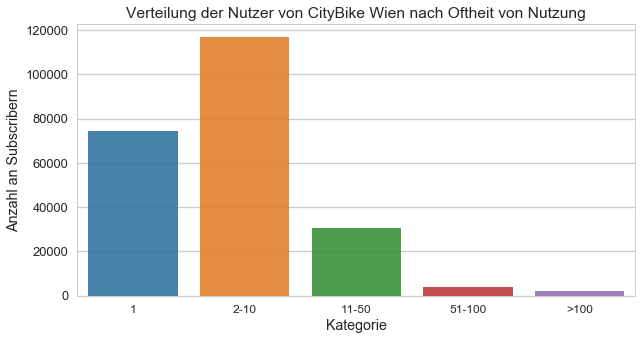

In [100]:
plt.figure(figsize=(10,5))

sns.set_style("whitegrid")
sns.set_context("talk")

index = ['1', '2-10', '11-50', '51-100', '>100']

ax = sns.barplot(aggregated_by_category_series.index, aggregated_by_category_series, alpha=0.9 )

ax.set_xlabel('Kategorie')
ax.set_ylabel('Anzahl an Subscribern')
ax.set_xticklabels(index, rotation='horizontal', fontsize=12)
ax.set_title('Verteilung der Nutzer von CityBike Wien nach Oftheit von Nutzung')

plt.show()

Aus dem Graphen ist ersichtlich, dass ein beträchtlicher Anteil der Nutzer One-Time User sind. Der größte Ant In der Arbeit Beschreiben

## Visuelle Darstellung der Auslastung des Systems nach Monat und Jahr

In [32]:
df2016_copy = df2016
df2017_copy = df2017

Damit pd.Grouper angewendet werden kann muss der Index ein DateTimeIndex sein:

In [33]:
df2016_copy.index = df2016_copy['Startdatum'] 
df2017_copy.index = df2017_copy['Startdatum']

Passt

In [34]:
type(df2016_copy.index)

pandas.core.indexes.datetimes.DatetimeIndex

Die Trips werden zuerst für das Jahr 2016 je Monat aggregiert

In [35]:
df2016_grouped_month = df2016.groupby(pd.Grouper(freq='M'))

aggregated_by_month_2016_dataframe = df2016_grouped_month.agg(np.size)

aggregated_by_month_2016 = aggregated_by_month_2016_dataframe['Startdatum']

agg2016 = aggregated_by_month_2016.to_frame('Anzahl_Fahrten_Monat')

Nun wird das Gleiche für das Jahr 2017 gemacht

In [36]:
df2017_grouped_month = df2017.groupby(pd.Grouper(freq='M'))

aggregated_by_month_2017_dataframe = df2017_grouped_month.agg(np.size)

aggregated_by_month_2017 = aggregated_by_month_2017_dataframe['Startdatum']

agg_2017 = aggregated_by_month_2017.to_frame('Anzahl_Fahrten_Monat')

Visualisierung der aggregierten Daten

### Statistische Kennzahlen zur Fahrtdauer

In [37]:
df_total_cleansed['Fahrtdauer'].describe()

count                   1897764
mean     0 days 00:26:06.235559
std      0 days 00:48:40.033084
min      0 days 00:02:00.103000
25%             0 days 00:09:42
50%             0 days 00:16:22
75%             0 days 00:28:21
max             6 days 08:24:51
Name: Fahrtdauer, dtype: object

### Statistische Kennzahlen zum Fahrtpreis 2016 bei Fahrten die mehr als 7 Euro gekostet haben

In [38]:
df2016[df2016['Fahrtpreis'] > 7]['Fahrtpreis'].describe()

count    4220.000000
mean       18.635308
std        28.181630
min        11.000000
25%        11.000000
50%        15.000000
75%        19.000000
max       600.000000
Name: Fahrtpreis, dtype: float64

## Stationen einlesen

In den folgenden Zellen werden eine Liste der Stationen in ein DataFrame transformiert. 

Die Datenquelle in XML-Format befindet sich unter der offiziellen (?) API unter http://dynamisch.citybikewien.at/citybike_xml.php . Da Pandas keine DataFrame-Erstellung aus XML unterstützt war es nötig die Daten von XML in JSON zu transformieren. Hierzu wurde ein öffentlich verfügbarer Dienst verwendet welcher unter der Adresse: http://www.utilities-online.info/xmltojson zu finden ist. 

Nachdem die Daten in einer JSON-Datei gespeichert wurden, werden diese in der unteren Zelle gelesen und mithilfe der JSON-Bibliothek in ein Python-Dictionary transformiert. Das Dictionary kann einfach in ein Pandas DataFrame-Objekt umgewandelt werden wodurch die nötigen Operationen vorgenommen werden können. Hierbei muss die Struktur des Dictionaries beachtet werden.

In [93]:
import json

data_file = open('CityBikeWien/Stationendaten.json', encoding='UTF-8')   
json_dict = json.load(data_file)
stations_dataframe = pd.DataFrame(json_dict['stations']['station'])

In [101]:
stations_dataframe[(stations_dataframe['id'] == 11) | (stations_dataframe['internal_id'] == 11)]

,boxes,description,free_bikes,free_boxes,id,internal_id,latitude,longitude,name,status
